# Image Regression with fastai2
> Using a subset of Kaggle's Facial Keypoints dataset.

- toc: false 
- badges: true
- comments: true
- author: Paul D
- image: images/2020-06-11-image-regression-title.jpg
- categories: [deep learning, fastai, fastai2, regression, image, face, facial, keypoints, recognition]
- hide: false

### Introduction

Following a similar structure to the fastai v2 literature, the next area we want to delve into is Image Regression. This is often refered to as 'Point Detection.' There are many practical implementations of this kind of model, for example, Snapchat's filters will use something similar to determine which parts of the image they should augment.

In this post, we look at Kaggle's [Facial Keypoints Dataset](https://www.kaggle.com/c/facial-keypoints-detection), which provides face images and coordinates for a number of keypoints denoting features such as nose tip, eye centers and mouth corners.

Thanks goes to by Dr. Yoshua Bengio of the University of Montreal, who provided the data for this Kaggle competition.

### Getting Started

To get started we import the usual libraries. In this dataset, we are working with grayscale images, so we advise `matplotlib` that this is the case. Finally, we import a couple of additional libraries, `cv2` which helps with us writing images out to disk and `patches`, which are a nice way to annotate images.

In [1]:
from utils import *
from fastai2.vision.widgets import *

matplotlib.rc('image', cmap='gray')
import cv2
from matplotlib.patches import Circle

Next we create a path instance pointing to our dataset location, and check out its contents.

In [2]:
path = Path('/home/pdito/AI/datasets/facial_keypoints')
Path.BASE_PATH = path
path.ls()

(#4) [Path('IdLookupTable.csv'),Path('training.csv'),Path('test.csv'),Path('SampleSubmission.csv')]

It looks like all our data is in CSV files, something we've not seen before. We start by loading training.csv into a Pandas Dataframe.

In [3]:
df = pd.read_csv(path/'training.csv')

Let's display the first row of data. 

*Note: we skip the final column. The reason will become apparent below, but basically our image data is stored this column, as a space delimited set of integers. Displaying it as part of the full table makes reading the data difficult.*

In [4]:
df.iloc[:1,:-1]

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,right_eye_outer_corner_x,right_eye_outer_corner_y,left_eyebrow_inner_end_x,left_eyebrow_inner_end_y,left_eyebrow_outer_end_x,left_eyebrow_outer_end_y,right_eyebrow_inner_end_x,right_eyebrow_inner_end_y,right_eyebrow_outer_end_x,right_eyebrow_outer_end_y,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,66.033564,39.002274,30.227008,36.421678,59.582075,39.647423,73.130346,39.969997,36.356571,37.389402,23.452872,37.389402,56.953263,29.033648,80.227128,32.228138,40.227609,29.002322,16.356379,29.647471,44.420571,57.066803,61.195308,79.970165,28.614496,77.388992,43.312602,72.935459,43.130707,84.485774


From reading the description of our dataset, we know our image sizes are 96x96, and the values abvove appear to provide the x, y coordinates for the point location in our image of the various features. We'll explore these in more detail later.

For completeness, let's grab the image (final) column from our dataframe for the first row.

In [5]:
df.iloc[:1,30:]

,Image
0,238 236 237 238 240 240 239 241 241 243 240 239 231 212 190 173 148 122 104 92 79 73 74 73 73 74 81 74 60 64 75 86 93 102 100 105 109 114 121 127 132 134 137 137 140 139 138 137 137 140 141 143 144 147 148 149 147 147 148 145 147 144 146 147 147 143 134 130 130 128 116 104 98 90 82 78 85 88 86 80 77 87 108 111 115 128 133 188 242 252 250 248 251 250 250 250 235 238 236 238 238 237 238 242 241 239 237 233 215 195 187 156 119 103 93 78 68 73 75 75 72 75 70 61 66 77 91 96 106 108 113 120 125 131 134 138 135 138 139 145 144 144 142 140 141 141 148 147 150 149 152 151 149 150 147 148 144 148 14...


We can convert this into a tensor and use fastai's `show_image` function to see what is looks like.

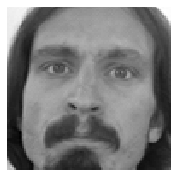

In [6]:
image = df.iloc[0]['Image']
image = tensor(np.fromstring(image, sep=' ').astype(np.float32).reshape(-1, 96))
show_image(image)

This confirms our understanding of the image data representation is correct. Next let's check the size our dataset

In [7]:
len(df)

7049

We know from the dataset information not all fields have values, so let's drop any records with NaN values from our dataframes, for the data points we care about.

In this example we're going to eventually look at the points corresponding to the nose tip, and the centre of both the left and right eyes.

Let's check how many records don't contain values for those columns.

In [8]:
print(df['nose_tip_x'].isnull().sum(), df['nose_tip_y'].isnull().sum())
print(df['left_eye_center_x'].isnull().sum(), df['left_eye_center_y'].isnull().sum())
print(df['right_eye_center_x'].isnull().sum(), df['right_eye_center_y'].isnull().sum())

0 0
10 10
13 13


Looks like at worst, we'll only loose 23 records (and maybe less if the missing fields are on any of the same records), so let's go ahead and drop rows with NaN values in those columns. We assume that if the left_eye_center_x is missing, the left_eye_center_y is also missing.

*Note: We don't need to working about the nose_tip points since there are no missing values.*

In [9]:
df = df[df['left_eye_center_x'].notna()]
df = df[df['right_eye_center_x'].notna()]

Let's now check we have indeed removed all rows with no values.

In [10]:
print(df['nose_tip_x'].isnull().sum(), df['nose_tip_y'].isnull().sum())
print(df['left_eye_center_x'].isnull().sum(), df['left_eye_center_y'].isnull().sum())
print(df['right_eye_center_x'].isnull().sum(), df['right_eye_center_y'].isnull().sum())

0 0
0 0
0 0


Excellent. And finally let's reset our row indexes (dropping rows from a Pandas Dataframe does not reset the row index numbers by default).

In [11]:
df.reset_index(drop=True, inplace=True)
len(df.index)

7033

So we've only lost 16 records from our dataset, which is great.

Since we now understand our dataset pretty well, we need to start getting it ready for fastai. We've spent a bunch of time trying to work out how to keep the image data as tensors, but we're yet to find a simple approach, so instead we've written a script to save these files down and store a reference of the file name in our dataframe, under the column heading `fname`.

*In the end, it made sense to do this anyway, since then we can use fastai's image transform functionality that should help our model generalise.*

In [12]:
path_train = path/'train'
os.mkdir(path_train)
df['fname'] = ""

i = 0
while i < len(df.index):
    img = np.array([int(v) for v in df.iloc[i]['Image'].split(" ")])
    img = img.reshape(96,96)
    filename = str(path_train) + '/' + str(i) + '.jpg'
    df.at[i, 'fname'] = filename
    cv2.imwrite(filename,img)
    i += 1

Let's now drop the image column from our dataframes, since all our images are stored in .jpgs now and referenced via the `fname` column.

In [13]:
del df['Image']

The next step is to get our data into a DataBlock. First we need to create functions to get our labels. For the purposes of this initial `DataBlock`, we're going to look to get just the nose tip point to begin with.

Our input data is a series of images, so we use an `ImageBlock`, and our targets are a series of points, so we use a `PointBlock`.

Fastai offers us a convenience function, ```ColReader``` which allows us to read values direct from a `DataFrame` column. Note, ```PointBlock``` expects a `list` for the x and y values.

In [14]:
data = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_x=ColReader('fname'),
    get_y=ColReader(['nose_tip_x','nose_tip_y'])
)

Let's now load create our ```DataLoaders``` by passing in our `DataFrame`.

In [15]:
dls = data.dataloaders(df)

And finally show a batch to see if our ```DataBlock``` is doing what we expect.

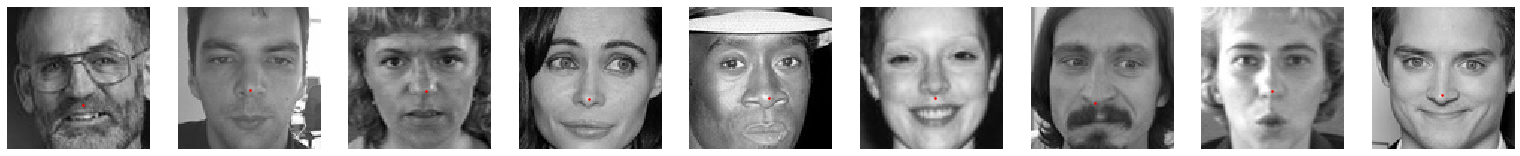

In [26]:
dls.show_batch(nrows=1)

Looks like fastai is understanding our data correctly. We can see a small red dot visible at the tip of the nose in each of our images.

Next, let's take a look at our `y` values to see how fastai stores them.

In [29]:
xb,yb = dls.one_batch()
a = yb[0]
a.shape, a

(torch.Size([1, 2]), tensor([[-0.0080,  0.0679]], device='cuda:0'))

We can see that fastai has converted the values for us into the scale it expects, where 0,0 is the center of the image, and the extremities across both axes are denoted as -1 or 1 from that central point. The values represent an interpolation between those points. 

Now we know we're on the right track, let's add the other two points we care about for this post. This is going to require a custom function to assign to our `get_y` in our `DataBlock`.  

We know fastai expects points to be in a `list` format, in other words, `[x, y]`. For multiple points, that simply becomes a list of lists, for example, `[[x1, y1], [x2, y2], [x3, y3]]`.

Below, we construct such a function, that when indexed into by row, returns a list of point lists.

In [30]:
def get_y(r):
    return [
    [r['nose_tip_x'],r['nose_tip_y']],
    [r['left_eye_center_x'],r['left_eye_center_y']],
    [r['right_eye_center_x'],r['right_eye_center_y']],
    ]

Now we have our new `get_y` function, we can create a new `DataBlock`. 

*Note: Even though we now have more than one point, we still only need to declare one `PointBlock`. Fastai is smart enough to know what to do when our `get_y` returns a list of points, instead of just an individual point.*

In [31]:
data = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_x=ColReader('fname'),
    get_y=get_y
)

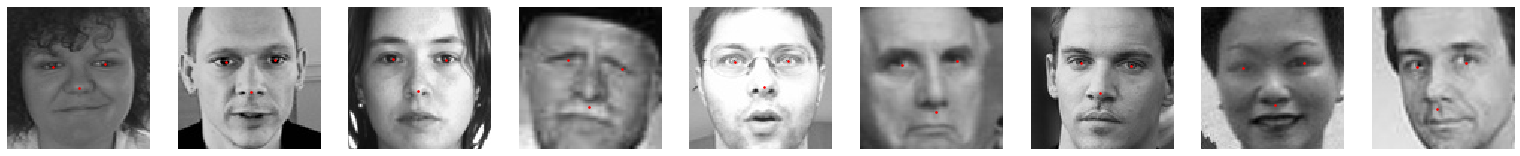

In [32]:
dls = data.dataloaders(df)
dls.show_batch(nrows=1)

Also appears to be working, we can now see the red dots indicating our points on the subject's eyes too. It's hard to believe how easy fastai makes this.

Finally, let's also check the size of our train / valid sets.

In [36]:
len(dls.train_ds), len(dls.valid_ds), len(dls.train_ds) + len(dls.valid_ds)

(5627, 1406, 7033)

This confirms all our data is being loaded. 

Now its time to create our `Learner`. Since this is a vision problem, we use `cnn_learner`, loading a pretrained `resnet18` architecture.

As in all regression problems, we need to tell fastai the range of our targets. We do so here by specifying `y_range=(-1,1)`.

*Note: coordinates in fastai and PyTorch are always rescaled between -1 and +1).*

In [43]:
learn = cnn_learner(dls, resnet18, metrics=rmse, y_range=(-1,1))

We then use `lr_find()` to help us identify a good learning rate.

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.033113110810518265)

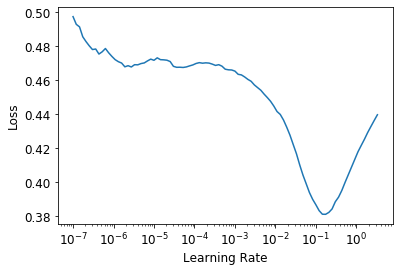

In [38]:
learn.lr_find()

Finally, we train our model using `fine_tune.`

In [44]:
lr = 1e-2
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,_rmse,time
0,0.174911,0.033285,0.182441,00:03


epoch,train_loss,valid_loss,_rmse,time
0,0.021516,0.009369,0.096794,00:04
1,0.021242,0.016620,0.128919,00:04
2,0.022095,0.007005,0.083694,00:04
3,0.018784,0.015414,0.124152,00:04
4,0.014738,0.011063,0.105179,00:04


So on average, we're a total of 0.1 off across all our labels in a range of -1 to 1, so in effect, 5%. That feels like a pretty good starting point for less than 30 seconds of train.

Let's visualise this by viewing some results. The left column represents our ground truth, the right column represents our predictions.

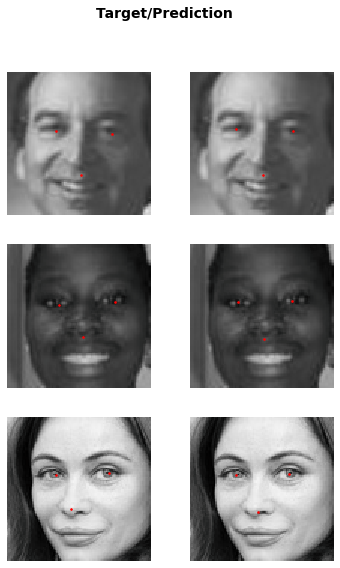

In [42]:
learn.show_results()

So what do our predictions actually look like? Let's pick an example to see.

(TensorPoint([[48.9711, 53.3791],
         [66.9962, 37.4717],
         [29.5481, 37.1540]]),
 tensor([ 0.0202,  0.1121,  0.3958, -0.2193, -0.3844, -0.2260]),
 tensor([ 0.0202,  0.1121,  0.3958, -0.2193, -0.3844, -0.2260]))

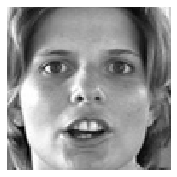

In [81]:
img = dls.valid_ds[1][0]
img.show()
learn.predict(img)

So our model's `learn.predict` function returns predicted `x, y` coordinates for our points in both the image pixel space and our model's `y_range` space. 

Let's write a function that will take an image, run a prediction on that image and overlay the points returned by our model on the image.

For this we use `matplotlib.patches`, which you can read more about [here](https://matplotlib.org/api/patches_api.html).

In [71]:
from matplotlib.pyplot import imshow

def predict_facial_points(image):
    preds = learn.predict(image)[0]
    patches = [Circle((preds[0][0], preds[0][1]), radius=1, color='red'),
            Circle((preds[1][0], preds[1][1]), radius=1, color='blue'),
            Circle((preds[2][0], preds[2][1]), radius=1, color='blue')
          ]
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    for p in patches:
        ax.add_patch(p)
    plt.show(fig)

Now we can pass the image from our training set to this function, to visualise how accurate our prediction is.

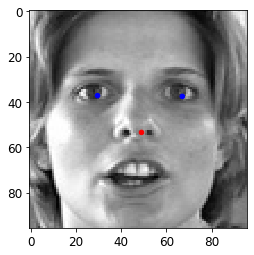

In [82]:
predict_facial_points(dls.valid_ds[1][0])

Finally, let's try on an image downloaded from the net.

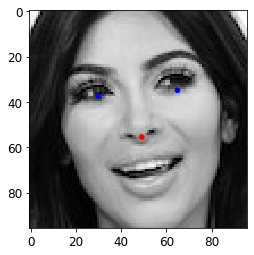

In [116]:
predict_facial_points(PILImage.create('kim_bw.jpg'))

A pretty decent attempt, however, we do feel this model won't generalise that well given the consistency in our training data. The position of the keypoints is fairly consistent image to image. Introducing transformations to this data would make training to decent results on the validation set very difficult, but would certainly help in the model's predictive accuracy.

Particularly rotations and croppings would be interesting to look at, since we suspect our model may be putting a higher weight on these keypoints *likely* being in this position, vs. detecting what eyes and noses actually look like.

Hope you enjoyed the post, as always, reach out to me on [Twitter](https://www.twitter.com/pdito) with any questions, tips or advice.